
### Table of Contents

* [1. Préparation des données](#section_1)
    * [1.1. Imports](#section_1_1)
    * [1.2. Récupération et description des données](#section_1_2)
    * [1.3. Nettoyage, exploration et création des features de base](#section_1_3)
* [2. Baseline: tree classifier, sélection des features de base](#section_2)
* [3. Optimisation hyperparamètetres tree classifier](#section_3) 
* [4. Méthodes ensemblistes](#section_4) 
    * [4.1. Bagging](#section_4_1)
        * [4.1.1. Random Forest](#section_4_1_1)
        * [4.1.2. Extratree Classifier](#section_4_1_2)   
    * [4.2. Boosting](#section_4_2)
        * [4.2.1. Adaboost](#section_4_2_1)
        * [4.2.2. XGBoost](#section_4_2_2)

### 1. Préparation des données <a class="anchor" id="section_1"></a>

#### 1.1. Imports <a class="anchor" id="section_1_1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier)
from sklearn.metrics import PrecisionRecallDisplay, log_loss, balanced_accuracy_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, average_precision_score, roc_curve
from sklearn import metrics
from itertools import combinations
from sklearn.inspection import permutation_importance

In [3]:
import graphviz
from sklearn.tree import export_graphviz

In [4]:
import xgboost
from xgboost import XGBClassifier

#### 1.2. Récupération et description des données <a class="anchor" id="section_1_2"></a>

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [6]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
include = ['object', 'float', 'int']
train_data.describe(include=include)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Vérification de l'exactitude des données "SibSp" et "Parch" sur la famille Ryerson, splittée entre Train et Test

In [11]:
mask = train_data['Name'].str.contains(r'Ryerson', na=False)
train_data.loc[mask, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C


In [12]:
mask2 = test_data['Name'].str.contains(r'Ryerson', na=False)
test_data.loc[mask2, :]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
24,916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.375,B57 B59 B63 B66,C
64,956,1,"Ryerson, Master. John Borie",male,13.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C
142,1034,1,"Ryerson, Mr. Arthur Larned",male,61.0,1,3,PC 17608,262.375,B57 B59 B63 B66,C


#### 1.3. Nettoyage, exploration et création des features de base <a class="anchor" id="section_1_3"></a>

Remplissage des données manquantes "Age" et "Fare" dans Train et Test

In [13]:
train_data.Age = train_data.Age.fillna(train_data.Age.median())
test_data.Age=test_data.Age.fillna(train_data.Age.median())

In [14]:
test_data.Fare=test_data.Fare.fillna(train_data.Fare.median())

Suppression des données manquantes "Embarked" dans Train 

In [15]:
train_data.dropna(subset=['Embarked'],inplace = True)

Création de 2 features supplémentaires: "family" et "fare_per_pass"

In [16]:
train_data['family']=train_data['SibSp']+train_data['Parch']
test_data['family']=test_data['SibSp']+test_data['Parch']

In [17]:
train_data['fare_per_pass']=train_data['Fare']/(1+train_data['SibSp']+train_data['Parch'])
test_data['fare_per_pass']=test_data['Fare']/(1+test_data['SibSp']+test_data['Parch'])

Encodage des features qualitatives "sex" et "embarked"

In [18]:
label_encoder = preprocessing.LabelEncoder()
train_data['Sex_labelled']=label_encoder.fit_transform(train_data["Sex"])
train_data['Embarked_labelled']=label_encoder.fit_transform(train_data["Embarked"])
test_data['Sex_labelled']=label_encoder.fit_transform(test_data["Sex"])
test_data['Embarked_labelled']=label_encoder.fit_transform(test_data["Embarked"])

Extraction de la feature 'Deck" dans Train

<AxesSubplot:xlabel='Deck', ylabel='count'>

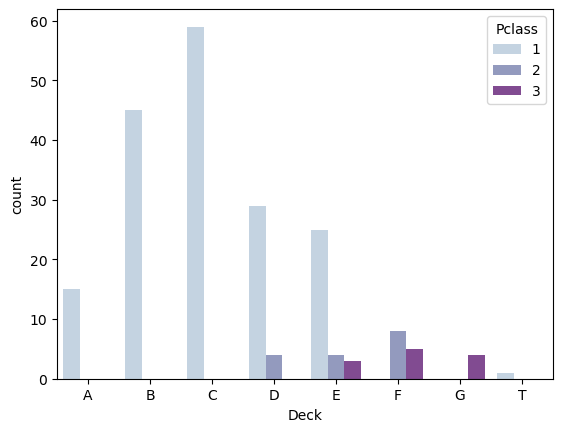

In [19]:
train_data["Deck"] = train_data["Cabin"].str.slice(0,1)
sns.countplot(x=train_data["Deck"], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'],hue = train_data['Pclass'], palette = 'BuPu')

Distribution des classes de survie dans les différentes features dans Train

<AxesSubplot:xlabel='Pclass', ylabel='count'>

<AxesSubplot:xlabel='Sex', ylabel='count'>

<AxesSubplot:xlabel='SibSp', ylabel='count'>

<AxesSubplot:xlabel='Parch', ylabel='count'>

<AxesSubplot:xlabel='Embarked', ylabel='count'>

<AxesSubplot:xlabel='Deck', ylabel='count'>

<AxesSubplot:xlabel='family', ylabel='count'>

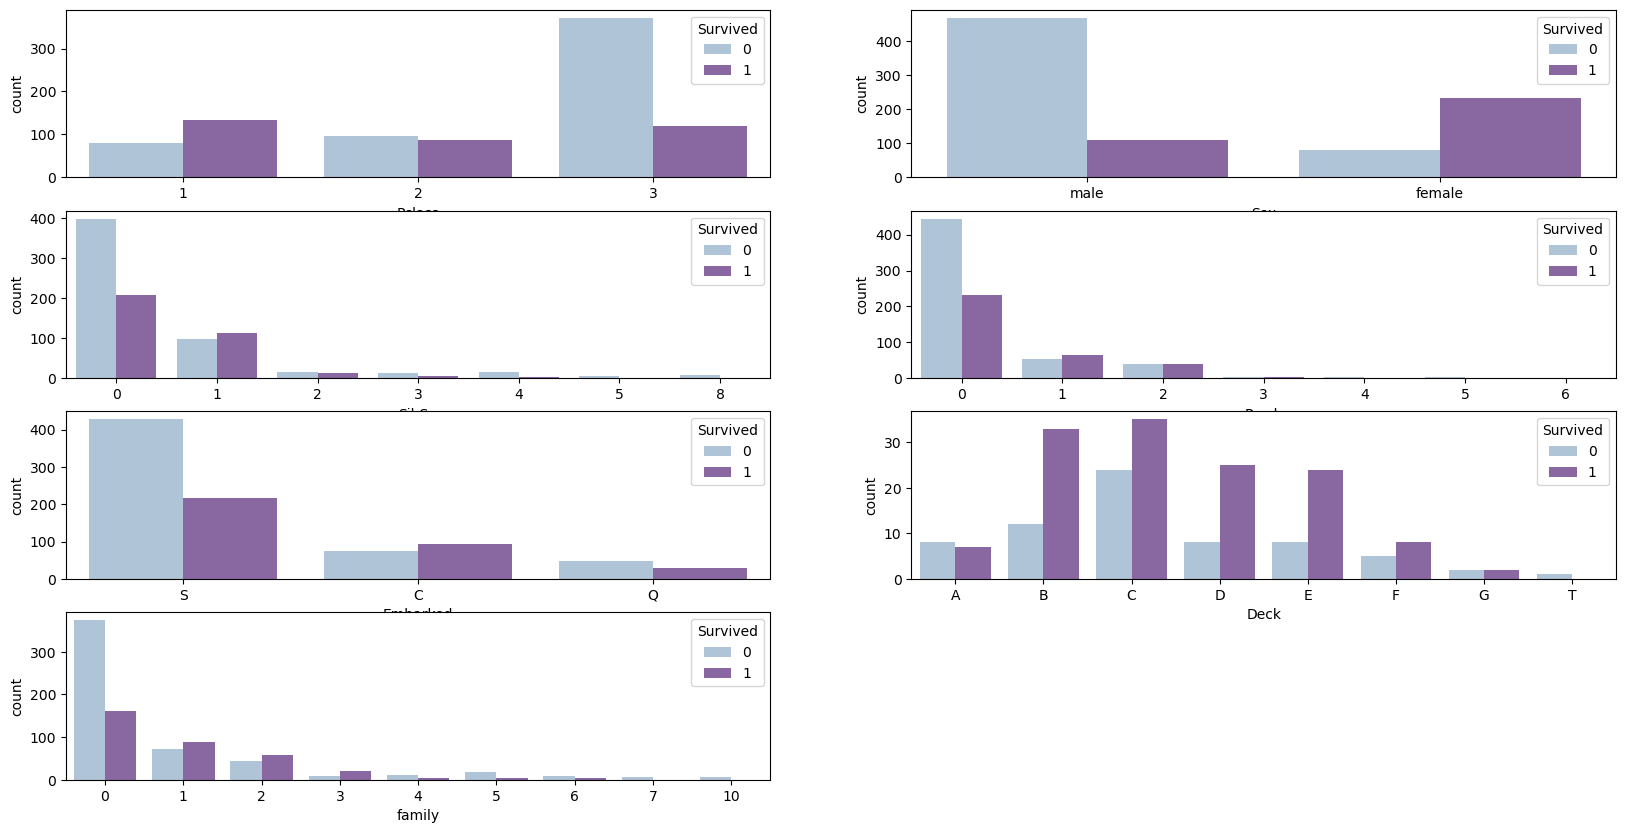

In [20]:
features = train_data[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Deck','family']]
fig , ax = plt.subplots(4,2, figsize = (20,10))     
for i , subplots in zip (features, ax.flatten()):  
    if i == 'Deck': 
        sns.countplot(x=features[i],hue = train_data['Survived'],ax = subplots, palette = 'BuPu', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
    else:
        sns.countplot(x=features[i],hue = train_data['Survived'],ax = subplots, palette = 'BuPu')
ax.flat[-1].set_visible(False)
plt.show()

<AxesSubplot:xlabel='Fare', ylabel='Count'>

<AxesSubplot:xlabel='fare_per_pass', ylabel='Count'>

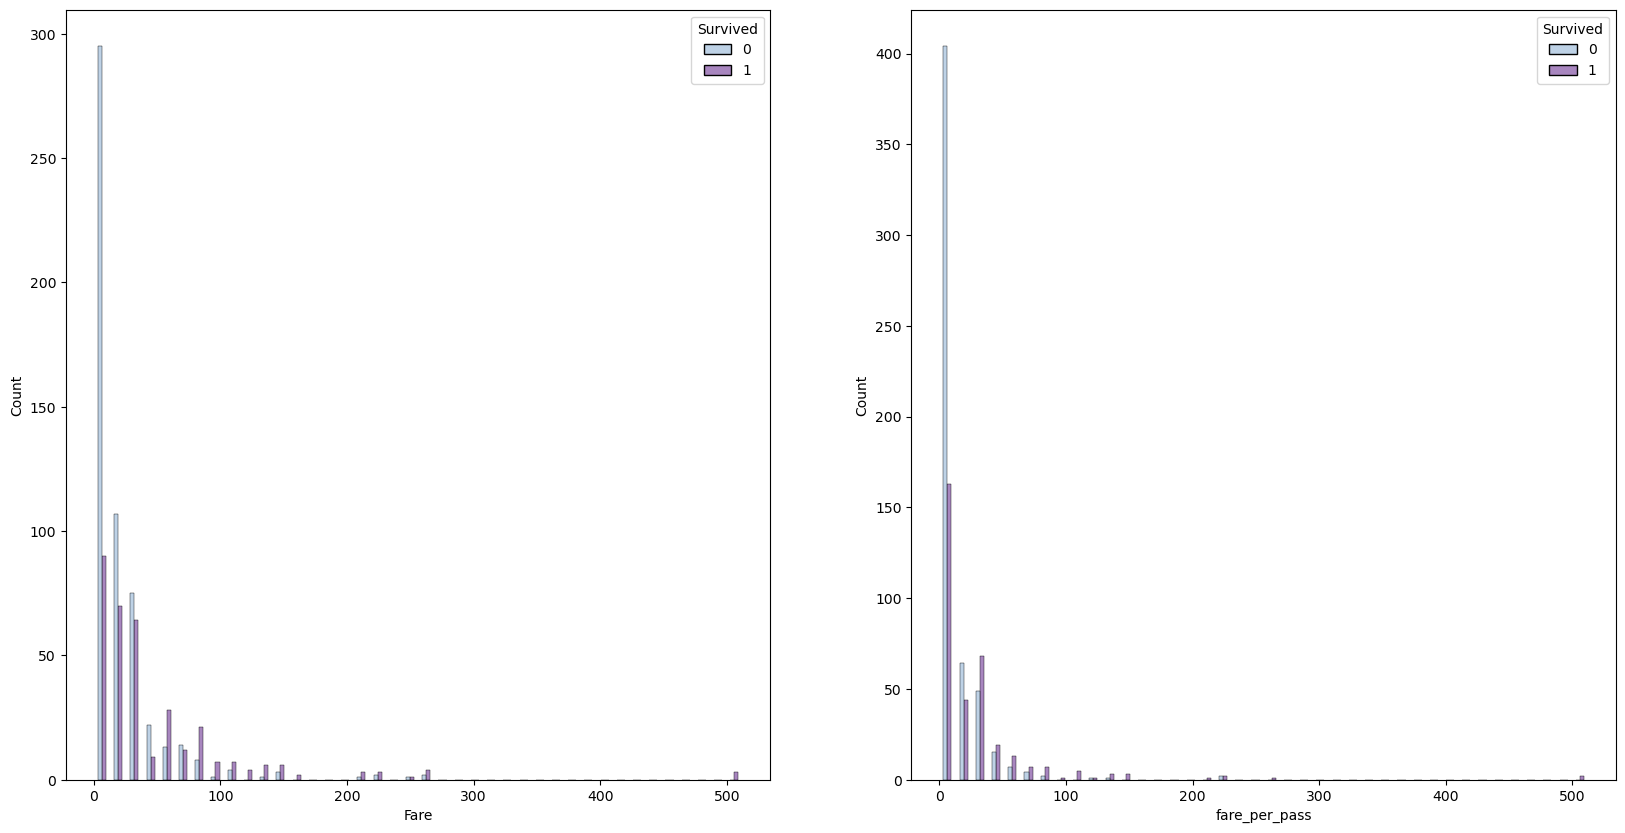

In [21]:
features = train_data[['Fare', 'fare_per_pass']]
fig , ax = plt.subplots(1,2, figsize = (20,10))     
for i , subplots in zip (features, ax.flatten()):  
        sns.histplot(x=features[i],hue = train_data['Survived'],ax = subplots,  multiple='dodge', shrink=0.5, bins=40, palette = 'BuPu')
plt.show()




[Text(-10.0, 0, ''),
 Text(0.0, 0, ''),
 Text(10.0, 0, ''),
 Text(20.0, 0, ''),
 Text(30.0, 0, ''),
 Text(40.0, 0, ''),
 Text(50.0, 0, ''),
 Text(60.0, 0, ''),
 Text(70.0, 0, ''),
 Text(80.0, 0, ''),
 Text(90.0, 0, '')]

[Text(5, 0, '[0-10]'),
 Text(15, 0, '[10-20]'),
 Text(25, 0, '[20-30]'),
 Text(35, 0, '[30-40]'),
 Text(45, 0, '[40-50]'),
 Text(55, 0, '[50-60]'),
 Text(65, 0, '[60-70]'),
 Text(75, 0, '[70-80]')]

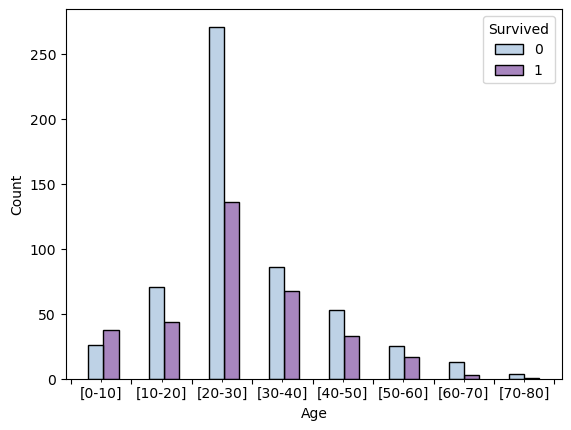

In [22]:
g=sns.histplot(data=train_data, x="Age", hue="Survived", multiple='dodge', shrink=0.5, bins=8, palette = 'BuPu')
g.set_xticklabels('')
g.set_xticks([5,15,25,35,45,55,65,75],      minor=True)
g.set_xticklabels(['[0-10]','[10-20]','[20-30]','[30-40]','[40-50]','[50-60]', '[60-70]', '[70-80]'], minor=True)

Exploration des distributions et corrélations dans Train

<Figure size 1000x600 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation Heatmap')

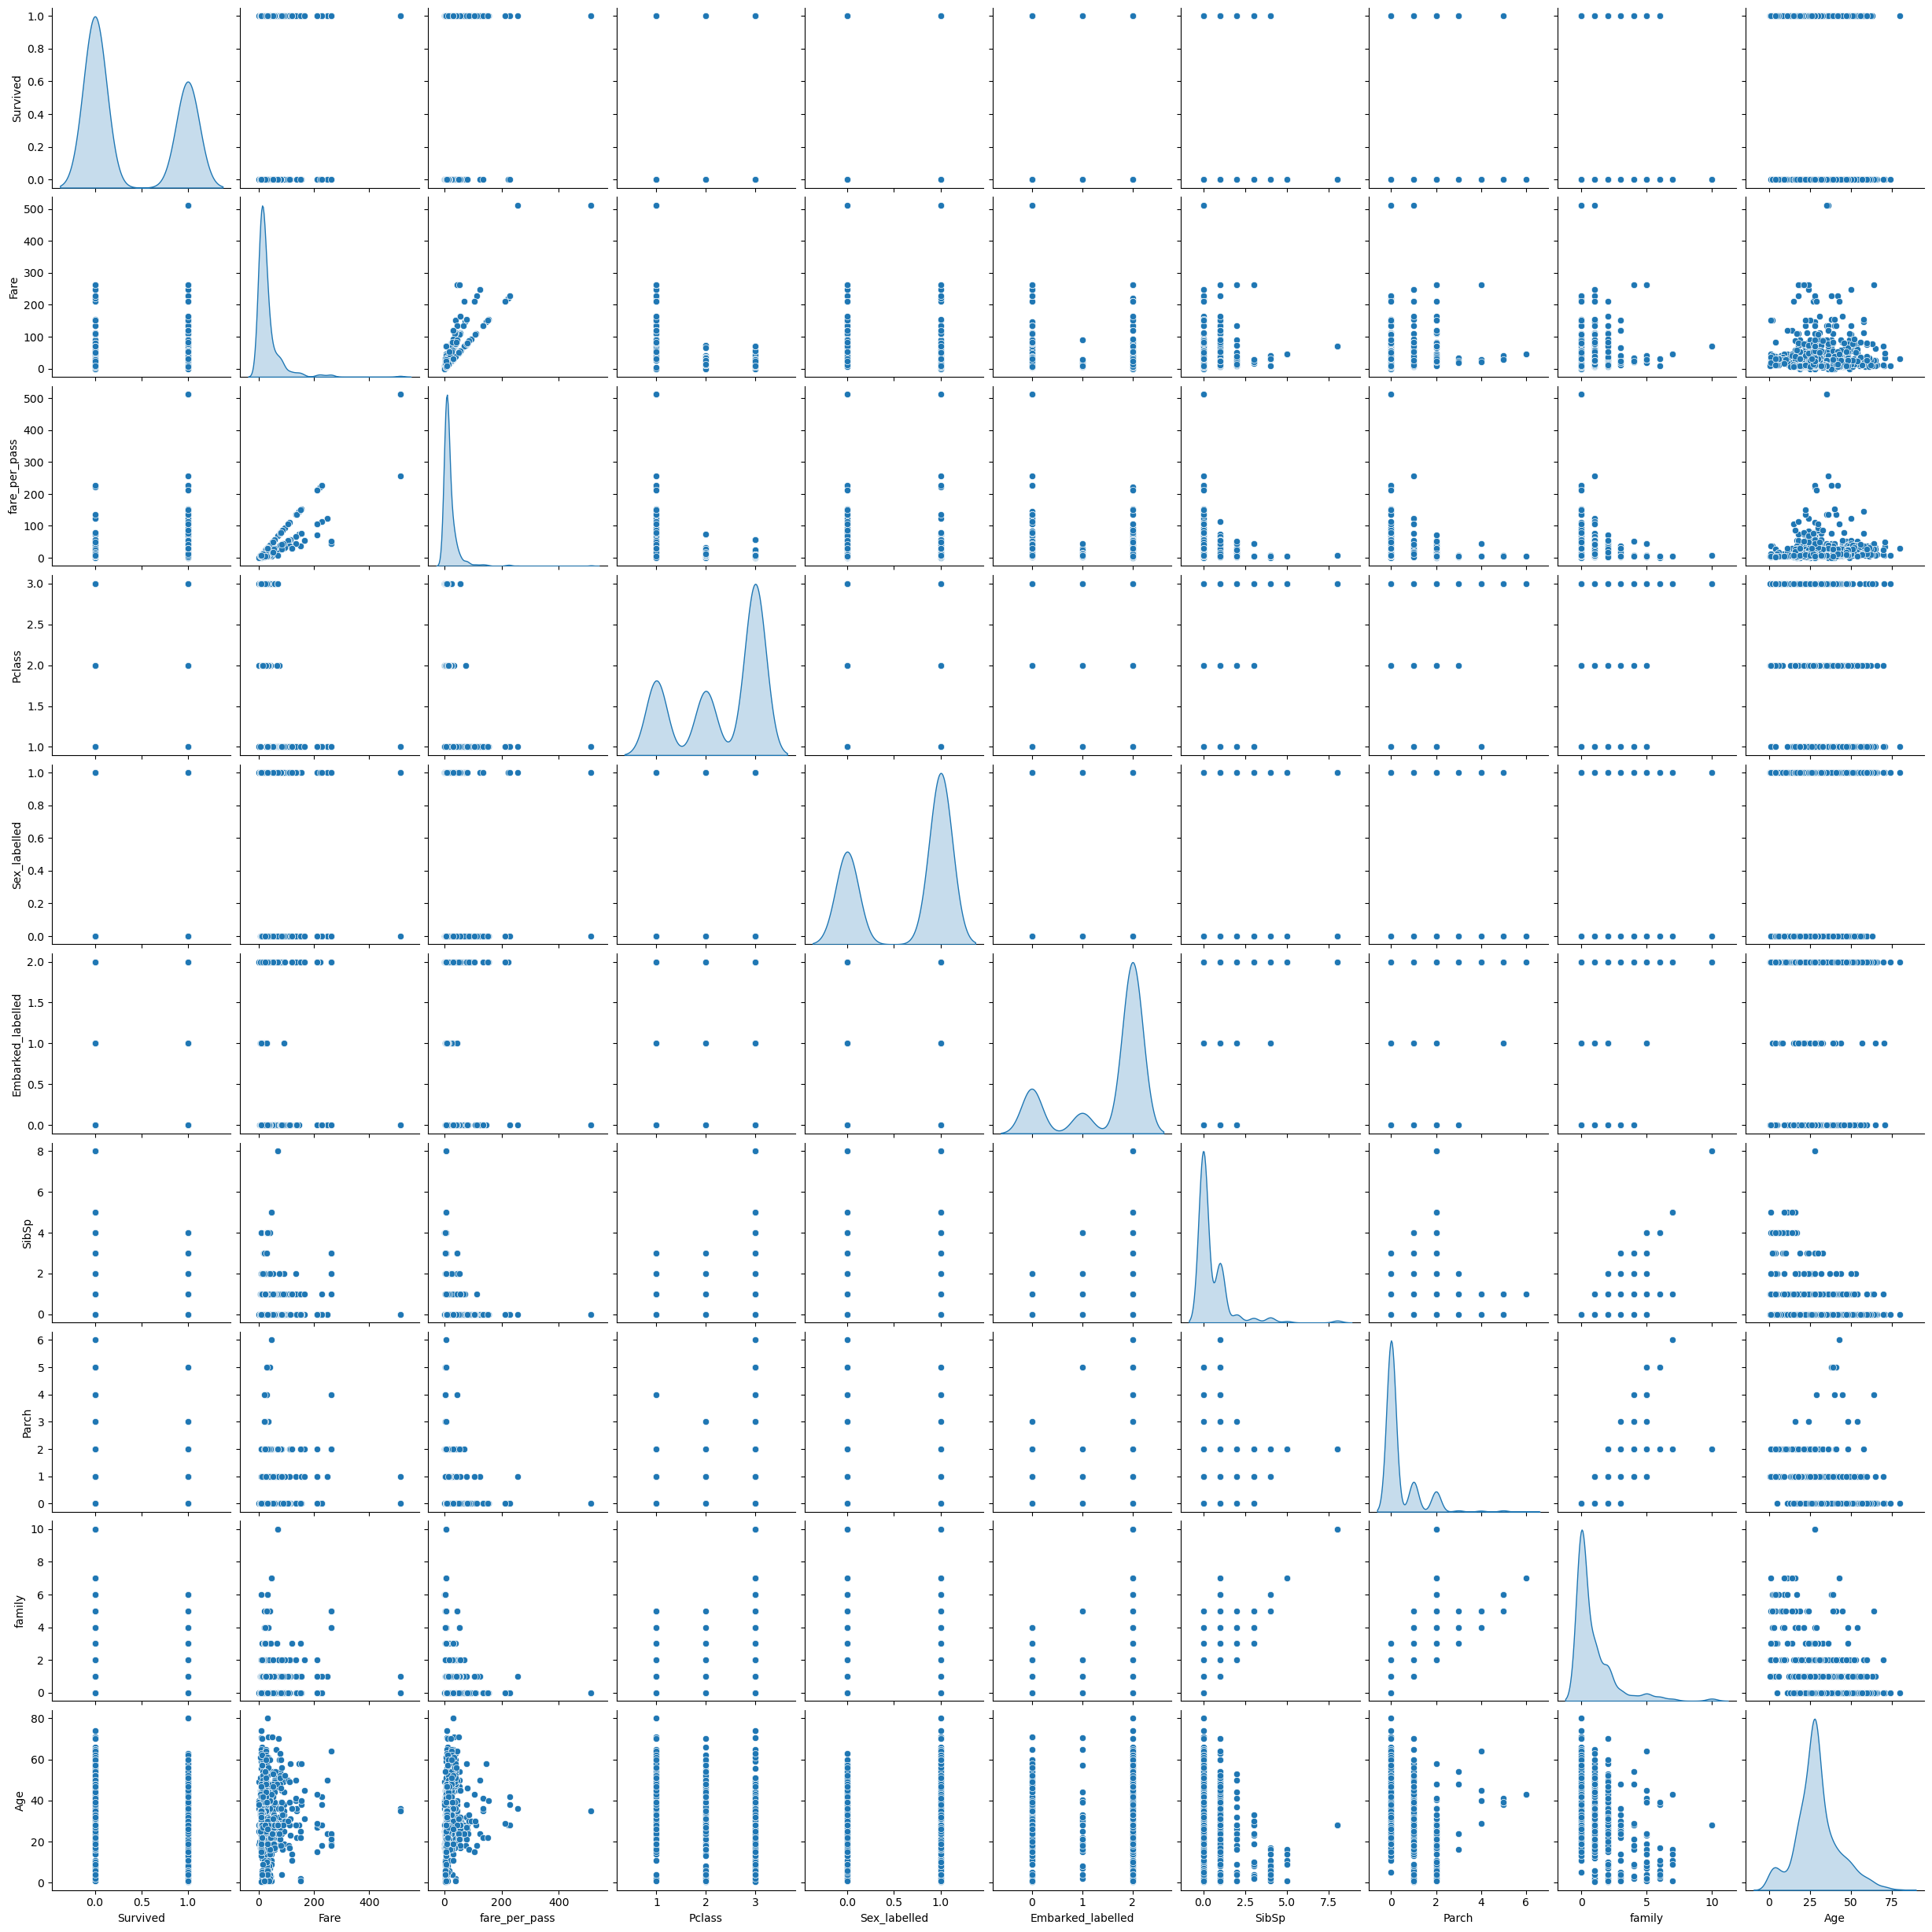

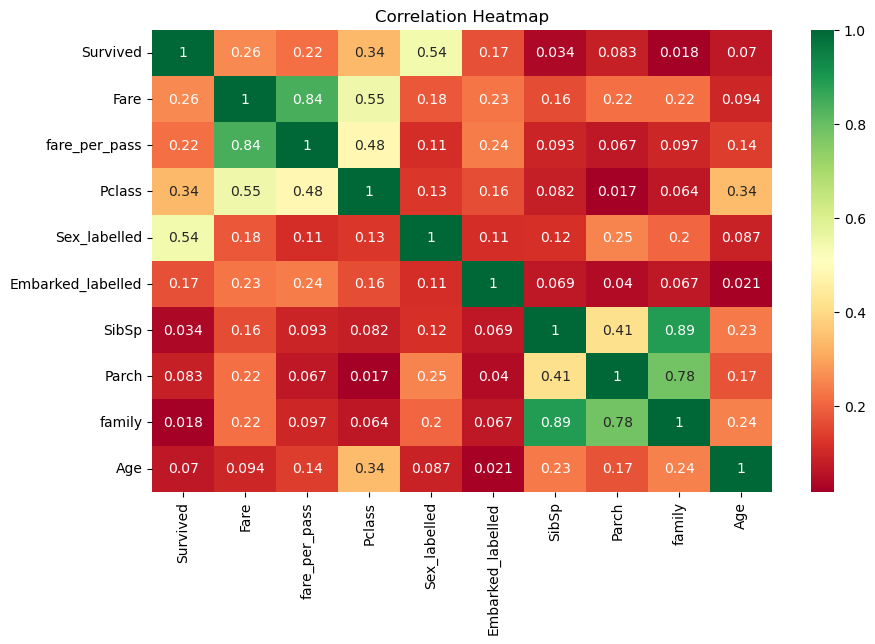

In [23]:
sns.pairplot(train_data[['Survived', "Fare", 'fare_per_pass', "Pclass", "Sex_labelled", "Embarked_labelled", "SibSp", 'Parch', 'family', 'Age']], diag_kind="kde")
plt.figure(figsize=(10,6))
sns.heatmap(train_data[['Survived', "Fare", 'fare_per_pass', "Pclass", "Sex_labelled", "Embarked_labelled", "SibSp", 'Parch', 'family', 'Age']].corr().abs(), annot=True, cmap='RdYlGn')
plt.title('Correlation Heatmap')
plt.show()

### 2. Baseline: tree classifier, sélection des features de base <a class="anchor" id="section_2"></a>

Comparaison d"un classifieur de base (tree classifier) entre 3 combinaisons différentes de features:
-modèle 1 = "Fare","Pclass", "Sex_labelled", "Embarked_labelled", "SibSp", 'Parch','Age'
-modèle 2 = "Fare","Pclass", "Sex_labelled", "Embarked_labelled", "family','Age'
-modèle 3 = "fare_per_pass","Pclass", "Sex_labelled", "Embarked_labelled", "SibSp", 'Parch','Age'

Choix du modèle 2, sur la base des différentes métriques, notamment d'aires sous courbe (roc_auc et average_precision),et pour réduire la dimentionnalité

In [24]:
def metrics_score(model, df, y_true, y_pred, y_score):
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "Balanced_accuracy","F1",
                                      "Jaccard", "Recall",
                                      "Precision", "roc", "avg_prec", "log_loss"],
                               columns=[model])       
    scores = []
    scores.append(metrics.accuracy_score(y_pred, 
                                   y_true))
    scores.append(metrics.balanced_accuracy_score(y_pred, 
                                   y_true))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    scores.append(metrics.roc_auc_score(y_true, 
                                          y_score))
    scores.append(metrics.average_precision_score(y_true, 
                                          y_score))
    scores.append(metrics.log_loss(y_true, y_score))
    temp_df[model] = scores
    return temp_df

In [25]:
X1 = train_data[["Fare","Pclass", "Sex_labelled", "Embarked_labelled", "SibSp", 'Parch','Age']]
y1 = train_data['Survived']


from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.25, random_state = 0)

clfbase=tree.DecisionTreeClassifier()


clf1=clfbase.fit(X_train1, y_train1)

y_pred_clf1= clf1.predict(X_test1)
y_score_clf1 = clf1.predict_proba(X_test1)[:,1]

df_metrics_compare = metrics_score("clf1", df=None,
                                   y_true=y_test1,
                                   y_pred=y_pred_clf1,
                                   y_score=y_score_clf1)
df_metrics_compare

,clf1
Accuracy,0.780269
Balanced_accuracy,0.773022
F1,0.780876
Jaccard,0.641028
Recall,0.780269
Precision,0.779344
roc,0.769231
avg_prec,0.647588
log_loss,7.449451


In [26]:
X = train_data[["Fare","Pclass", "Sex_labelled", "Embarked_labelled", "family",'Age']]
y = train_data['Survived']


from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.25, random_state = 0)

clfbase=tree.DecisionTreeClassifier()


clf2=clfbase.fit(X_train2, y_train2)

y_pred_clf2= clf2.predict(X_test2)
y_score_clf2 = clf2.predict_proba(X_test2)[:,1]

df_metrics_compare = metrics_score("clf2", df=df_metrics_compare,
                                   y_true=y_test2,
                                   y_pred=y_pred_clf2,
                                   y_score=y_score_clf2)
df_metrics_compare

,clf1,clf2
Accuracy,0.780269,0.784753
Balanced_accuracy,0.773022,0.778645
F1,0.780876,0.786031
Jaccard,0.641028,0.646417
Recall,0.780269,0.784753
Precision,0.779344,0.783370
roc,0.769231,0.772311
avg_prec,0.647588,0.654250
log_loss,7.449451,7.291453


In [27]:
X = train_data[["fare_per_pass","Pclass", "Sex_labelled", "Embarked_labelled", "SibSp", 'Parch','Age']]
y = train_data['Survived']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

clfbase=tree.DecisionTreeClassifier()


clf3=clfbase.fit(X_train, y_train)

y_pred_clf3= clf3.predict(X_test)
y_score_clf3 = clf3.predict_proba(X_test)[:,1]

df_metrics_compare = metrics_score("clf3", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=y_pred_clf3,
                                   y_score=y_score_clf3)
df_metrics_compare

,clf1,clf2,clf3
Accuracy,0.780269,0.784753,0.744395
Balanced_accuracy,0.773022,0.778645,0.736637
F1,0.780876,0.786031,0.746830
Jaccard,0.641028,0.646417,0.593254
Recall,0.780269,0.784753,0.744395
Precision,0.779344,0.783370,0.742028
roc,0.769231,0.772311,0.722736
avg_prec,0.647588,0.654250,0.601683
log_loss,7.449451,7.291453,8.694731


In [28]:
class_names = clf2.classes_
feature_names = X_train2.columns
target_names=np.array(['dead', 'alive'])

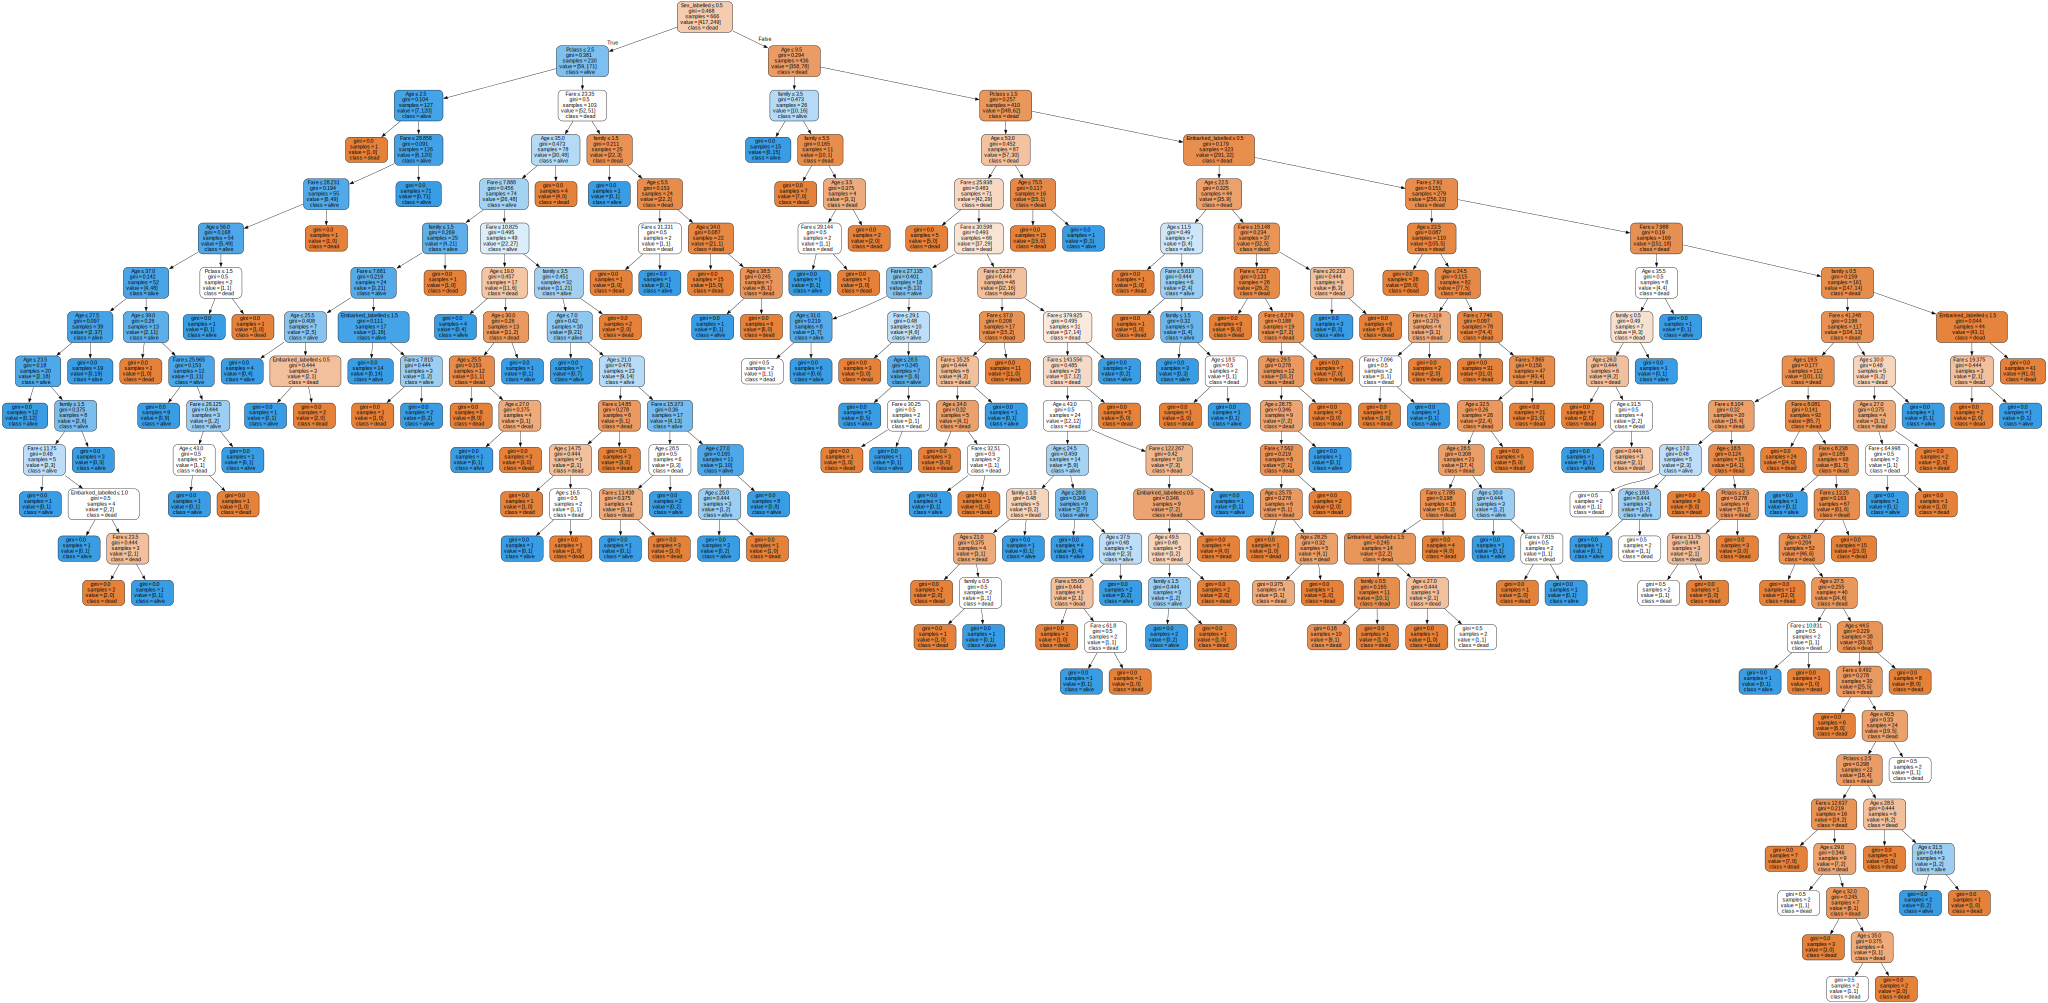

In [29]:
dot_data = tree.export_graphviz(clf2, out_file=None, 
                                feature_names=feature_names,
                                class_names=target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

roc_auc_score for DecisionTree:  0.7723110223110223


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 1.0, 'Receiver Operating Characteristic - DecisionTree')

([<matplotlib.lines.Line2D at 0x7f08b9566c50>],
 [<matplotlib.lines.Line2D at 0x7f08b9566dd0>])

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

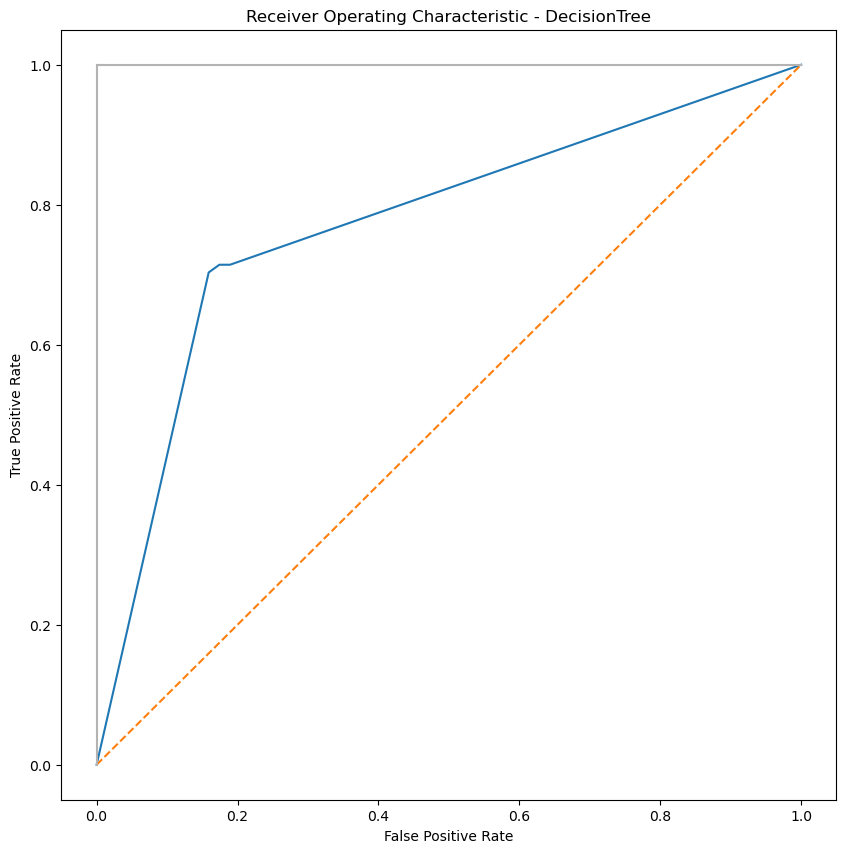

In [30]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test2, y_score_clf2)
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test2, y_score_clf2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

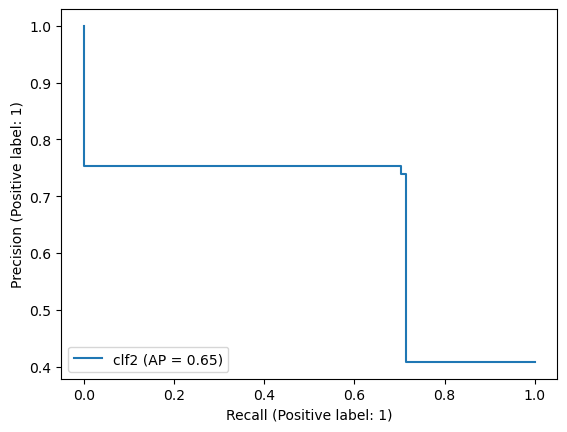

In [31]:
display = PrecisionRecallDisplay.from_predictions(y_test2, y_score_clf2, name="clf2")

### 3. Optimisation hyperparamètres tree classifier <a class="anchor" id="section_3"></a>

In [32]:
X = train_data[["Fare","Pclass", "Sex_labelled", "Embarked_labelled", 'family','Age']]
y = train_data['Survived']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


scoring = {"AUC": "roc_auc", "Accuracy": "balanced_accuracy", "AVG":"average_precision"}


param_grid = {'min_samples_split': range(2,10),
              'min_samples_leaf': range(2,10),
              'max_depth': range(5,15),
              'criterion' :['gini', 'entropy']
             }

clfbase_best = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring= scoring, n_jobs=-1, cv=5,return_train_score=True, refit="AUC", verbose=True)
clfbase_best.fit(X_train, y_train)
print(clfbase_best.best_estimator_)
print(clfbase_best.best_score_)
print(clfbase_best.best_params_)


Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 15),
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split': range(2, 10)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'AVG': 'average_precision',
                      'Accuracy': 'balanced_accuracy'},
             verbose=True)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=7, min_samples_split=4)
0.8568712224993267
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 4}


In [33]:
y_pred_clfbase_best = clfbase_best.predict(X_test)
y_score_clfbase_best = clfbase_best.predict_proba(X_test)[:,1]

In [34]:
df_metrics_compare = metrics_score("clfbase_best", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=y_pred_clfbase_best,
                                   y_score=y_score_clfbase_best)
df_metrics_compare

,clf1,clf2,clf3,clfbase_best
Accuracy,0.780269,0.784753,0.744395,0.766816
Balanced_accuracy,0.773022,0.778645,0.736637,0.765135
F1,0.780876,0.786031,0.746830,0.771392
Jaccard,0.641028,0.646417,0.593254,0.619900
Recall,0.780269,0.784753,0.744395,0.766816
Precision,0.779344,0.783370,0.742028,0.766079
roc,0.769231,0.772311,0.722736,0.807734
avg_prec,0.647588,0.654250,0.601683,0.778270
log_loss,7.449451,7.291453,8.694731,1.255707


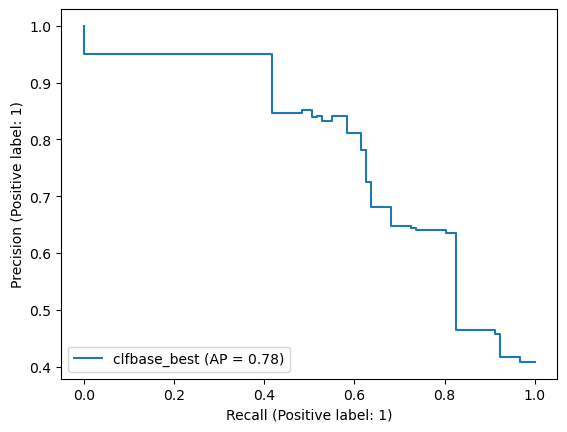

In [35]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_score_clfbase_best, name="clfbase_best")

roc_auc_score for best DecisionTree:  0.8077339327339328


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 1.0, 'Receiver Operating Characteristic - best DecisionTree')

([<matplotlib.lines.Line2D at 0x7f08b9219910>],
 [<matplotlib.lines.Line2D at 0x7f08b9219fd0>])

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

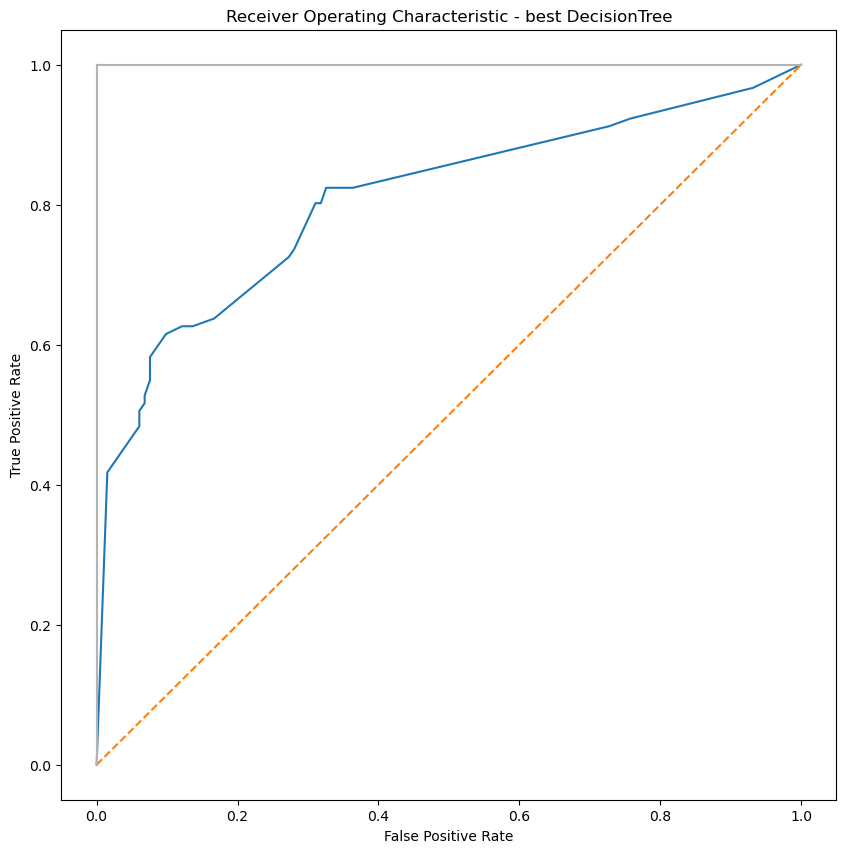

In [36]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_clfbase_best)
print('roc_auc_score for best DecisionTree: ', roc_auc_score(y_test, y_score_clfbase_best))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - best DecisionTree')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
par_best=clfbase_best.best_params_
par_best=list(par_best.values())
par_best

['gini', 6, 7, 4]

In [38]:
par_best=clfbase_best.best_params_
par_best=list(par_best.values())


X = train_data[["Fare","Pclass", "Sex_labelled", "Embarked_labelled", "family",'Age']]
y = train_data['Survived']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


clfbase_best2 = tree.DecisionTreeClassifier(criterion=par_best[0], max_depth=par_best[1], min_samples_leaf=par_best[2], min_samples_split=par_best[3])
clfbase_best2=clfbase_best2.fit(X_train, y_train)


class_names = clfbase_best2.classes_
target_names=np.array(['dead', 'alive'])

In [39]:
class_names = clfbase_best2.classes_
feature_names = X_train.columns
target_names=np.array(['dead', 'alive'])

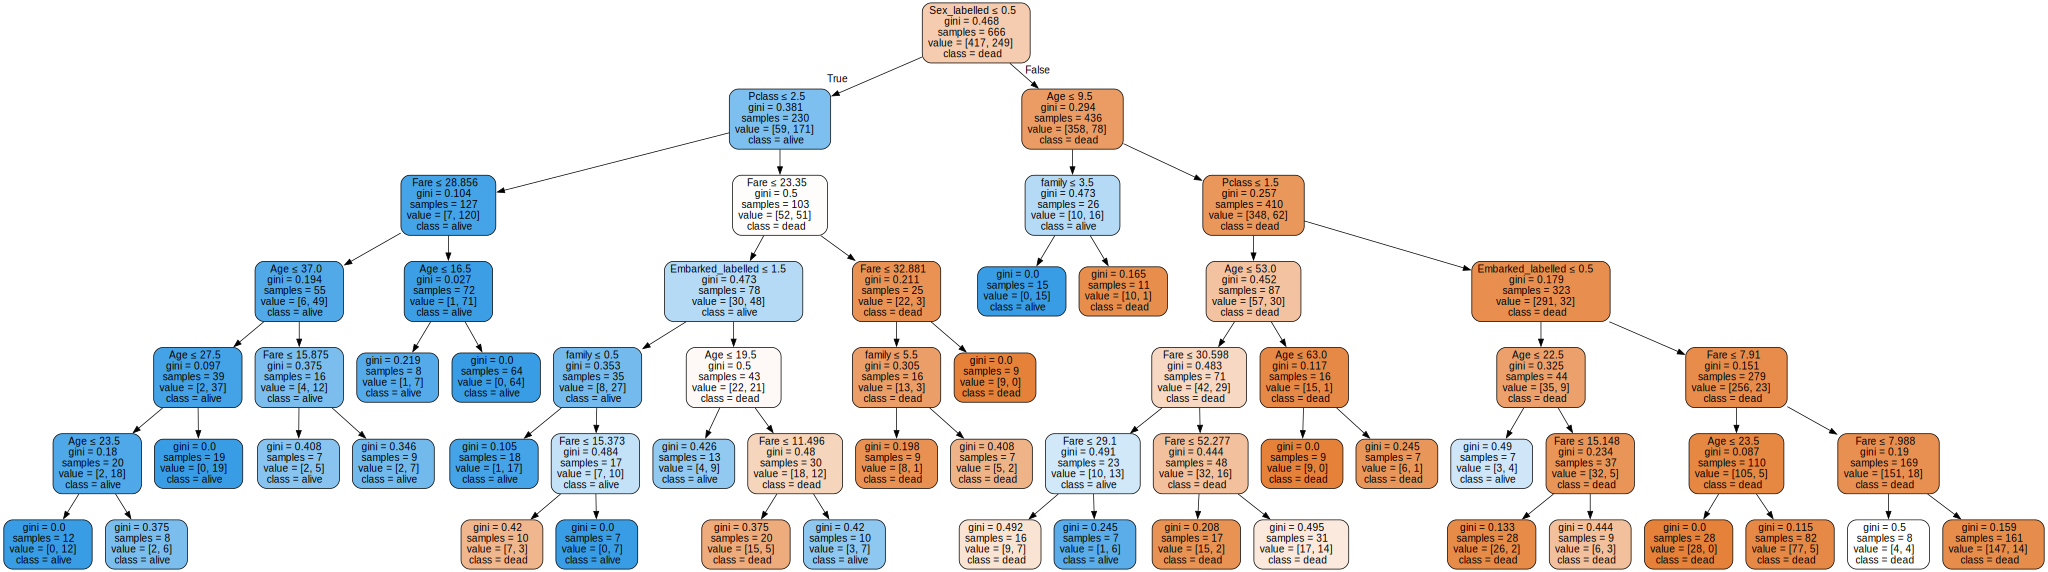

In [40]:
dot_data = tree.export_graphviz(clfbase_best2, out_file=None, 
                                feature_names=feature_names,
                                class_names=target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [41]:
X = test_data[["Fare","Pclass", "Sex_labelled", "Embarked_labelled", "family",'Age']]
predictions1 = clfbase_best2.predict(X)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions1})
output.to_csv('submission1.csv', index=False)


submission score = 0.7799

### 4. Méthodes ensemblistes <a class="anchor" id="section_4"></a>

#### 4.1. Bagging <a class="anchor" id="section_4_1"></a>

##### 4.1.1 Random Forest <a class="anchor" id="section_4_1_1"></a>

In [42]:
X = train_data[["Fare","Pclass", "Sex_labelled", "Embarked_labelled", "family",'Age']]
y = train_data['Survived']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


scoring = {"AUC": "roc_auc", "Accuracy": "balanced_accuracy", "AVG":"average_precision"}


param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10],
    'criterion' :['gini', 'entropy']
}

rf= GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, scoring= scoring, n_jobs=-1, cv=5,return_train_score=True, refit="AUC", verbose=True)
rf.fit(X_train, y_train)
print(rf.best_estimator_)
print(rf.best_score_)
print(rf.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'AVG': 'average_precision',
                      'Accuracy': 'balanced_accuracy'},
             verbose=True)

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=500,
                       random_state=42)
0.8804186834802767
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 500}


In [43]:
y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:,1]

In [44]:
df_metrics_compare = metrics_score("rf", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=y_pred_rf,
                                   y_score=y_score_rf)
df_metrics_compare

,clf1,clf2,clf3,clfbase_best,rf
Accuracy,0.780269,0.784753,0.744395,0.766816,0.780269
Balanced_accuracy,0.773022,0.778645,0.736637,0.765135,0.781154
F1,0.780876,0.786031,0.746830,0.771392,0.784942
Jaccard,0.641028,0.646417,0.593254,0.619900,0.637341
Recall,0.780269,0.784753,0.744395,0.766816,0.780269
Precision,0.779344,0.783370,0.742028,0.766079,0.780670
roc,0.769231,0.772311,0.722736,0.807734,0.840743
avg_prec,0.647588,0.654250,0.601683,0.778270,0.830784
log_loss,7.449451,7.291453,8.694731,1.255707,0.465348


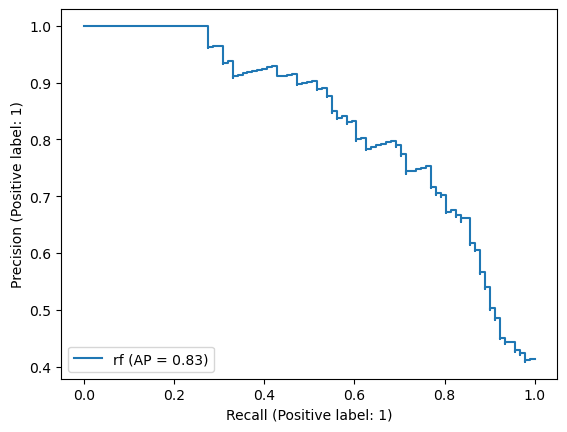

In [45]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_score_rf, name="rf")

roc_auc_score for Random Forest:  0.8407425907425907


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 1.0, 'Receiver Operating Characteristic - Random Forest')

([<matplotlib.lines.Line2D at 0x7f08b93ef890>],
 [<matplotlib.lines.Line2D at 0x7f08b93ef150>])

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

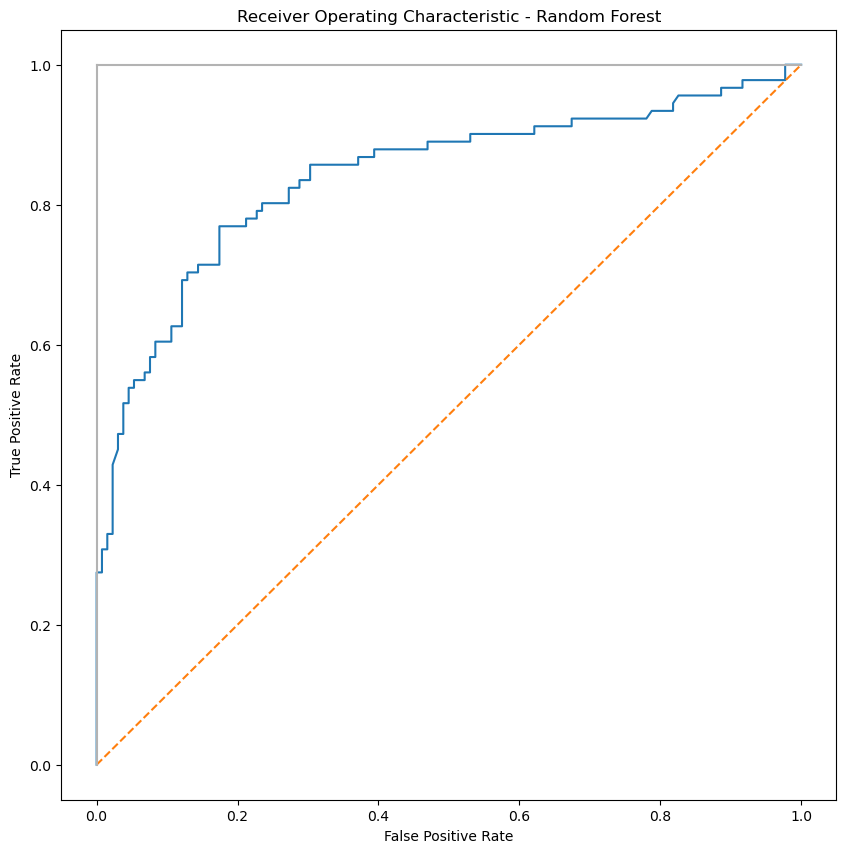

In [46]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_rf)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score_rf))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
rfbest= RandomForestClassifier (criterion='entropy', max_depth=6, n_estimators=500,
                       random_state=42)
rfbest=rfbest.fit(X_train, y_train)

Evaluation de l'importance des features selon 2 méthodes:  impurity-based feature importance and permutation importance (sur train and test)

Text(0.5, 1.0, 'Random Forest Feature Importances (MDI)')

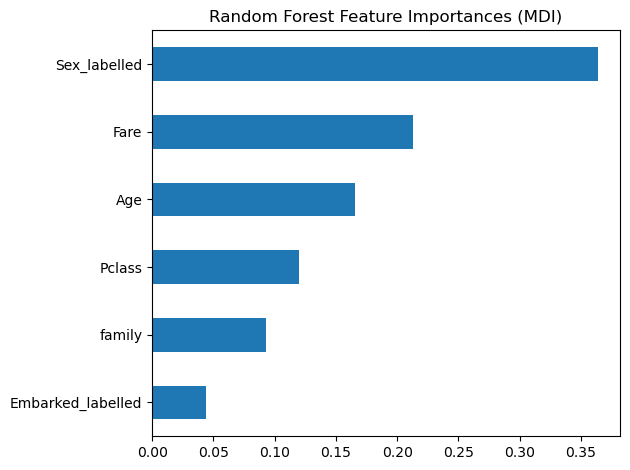

In [48]:
mdi_importances = pd.Series(
    rfbest.feature_importances_, index=X_train.columns
).sort_values(ascending=True)
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

Text(0.5, 1.0, 'Permutation Importances (test set)')

Text(0.5, 0, 'Decrease in accuracy score')

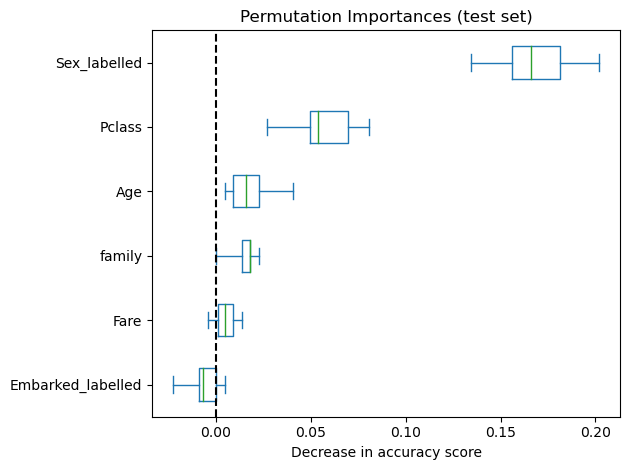

In [49]:
result = permutation_importance(
    rfbest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Text(0.5, 1.0, 'Permutation Importances (train set)')

Text(0.5, 0, 'Decrease in accuracy score')

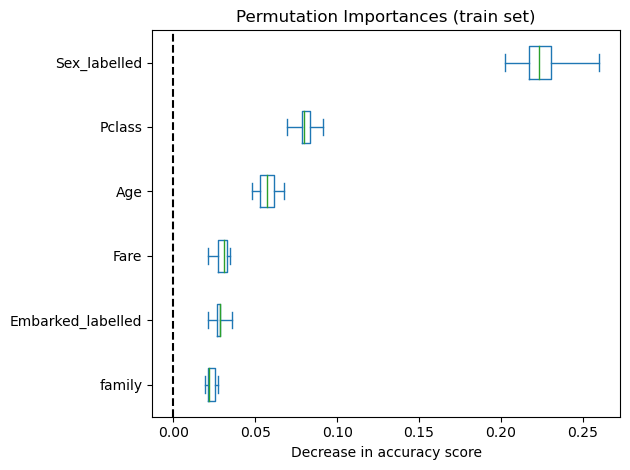

In [50]:
result = permutation_importance(
    rfbest, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

#### 4.1.2. Extratree Classifier <a class="anchor" id="section_4_1_2"></a>

In [51]:
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10],
    'criterion' :['gini', 'entropy']
}

extrarf= GridSearchCV(ExtraTreesClassifier(random_state=42, bootstrap=False), param_grid=param_grid, scoring= scoring, n_jobs=-1, cv=5,return_train_score=True, refit="AUC", verbose=True)
extrarf.fit(X_train, y_train)
print(extrarf.best_estimator_)
print(extrarf.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'AVG': 'average_precision',
                      'Accuracy': 'balanced_accuracy'},
             verbose=True)

ExtraTreesClassifier(max_depth=6, n_estimators=500, random_state=42)
0.8753740911166531


In [52]:
y_pred_extrarf = extrarf.predict(X_test)
y_score_extrarf = extrarf.predict_proba(X_test)[:,1]

In [53]:
df_metrics_compare = metrics_score("extrarf", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=y_pred_extrarf,
                                   y_score=y_score_extrarf)
df_metrics_compare

,clf1,clf2,clf3,clfbase_best,rf,extrarf
Accuracy,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785
Balanced_accuracy,0.773022,0.778645,0.736637,0.765135,0.781154,0.777078
F1,0.780876,0.786031,0.746830,0.771392,0.784942,0.780933
Jaccard,0.641028,0.646417,0.593254,0.619900,0.637341,0.631021
Recall,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785
Precision,0.779344,0.783370,0.742028,0.766079,0.780670,0.776389
roc,0.769231,0.772311,0.722736,0.807734,0.840743,0.831002
avg_prec,0.647588,0.654250,0.601683,0.778270,0.830784,0.824767
log_loss,7.449451,7.291453,8.694731,1.255707,0.465348,0.469001


#### 4.2. Boosting <a class="anchor" id="section_4_2"></a>

##### 4.2.1. AdaBoost <a class="anchor" id="section_4_2_1"></a>

In [54]:
param_grid = { 
    'n_estimators': [50, 100, 200, 500],
    'learning_rate':  [0.0001, 0.001, 0.01, 0.1, 1.0],
}

adaboost= GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, scoring= scoring, n_jobs=-1, cv=5,return_train_score=True, refit="AUC", verbose=True)
adaboost.fit(X_train, y_train)
print(adaboost.best_estimator_)
print(adaboost.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200, 500]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'AVG': 'average_precision',
                      'Accuracy': 'balanced_accuracy'},
             verbose=True)

AdaBoostClassifier(learning_rate=0.1, n_estimators=200)
0.8712065404475042


In [55]:
y_pred_adaboost = adaboost.predict(X_test)
y_score_adaboost = adaboost.predict_proba(X_test)[:,1]

In [56]:
df_metrics_compare = metrics_score("adaboost", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=y_pred_adaboost,
                                   y_score=y_score_adaboost)
df_metrics_compare

,clf1,clf2,clf3,clfbase_best,rf,extrarf,adaboost
Accuracy,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785,0.771300
Balanced_accuracy,0.773022,0.778645,0.736637,0.765135,0.781154,0.777078,0.764731
F1,0.780876,0.786031,0.746830,0.771392,0.784942,0.780933,0.772921
Jaccard,0.641028,0.646417,0.593254,0.619900,0.637341,0.631021,0.628321
Recall,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785,0.771300
Precision,0.779344,0.783370,0.742028,0.766079,0.780670,0.776389,0.769628
roc,0.769231,0.772311,0.722736,0.807734,0.840743,0.831002,0.836747
avg_prec,0.647588,0.654250,0.601683,0.778270,0.830784,0.824767,0.818512
log_loss,7.449451,7.291453,8.694731,1.255707,0.465348,0.469001,0.659773


##### 4.2.2. XGBoost <a class="anchor" id="section_4_2_2"></a>

On fixe d'abord un learning rate élevé et un nombre d'arbres faible et on optimise les hyperparamètres sur cette première base

In [57]:
param_grid =  {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7]
        }

xgboost= GridSearchCV(XGBClassifier(learning_rate=0.1, n_estimators=200), param_grid=param_grid, scoring= scoring, n_jobs=-1, cv=5,return_train_score=True, refit="AUC", verbose=True)
xgboost.fit(X_train, y_train)
print(xgboost.best_estimator_)
print(xgboost.best_score_)
print(xgboost.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
0.8913978420972521
{'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}


In [58]:
y_pred_xgboost = xgboost.predict(X_test)
y_score_xgboost = xgboost.predict_proba(X_test)[:,1]

In [59]:
df_metrics_compare = metrics_score("xgboost", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=y_pred_xgboost,
                                   y_score=y_score_xgboost)
df_metrics_compare

,clf1,clf2,clf3,clfbase_best,rf,extrarf,adaboost,xgboost
Accuracy,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785,0.771300,0.802691
Balanced_accuracy,0.773022,0.778645,0.736637,0.765135,0.781154,0.777078,0.764731,0.801512
F1,0.780876,0.786031,0.746830,0.771392,0.784942,0.780933,0.772921,0.805365
Jaccard,0.641028,0.646417,0.593254,0.619900,0.637341,0.631021,0.628321,0.669415
Recall,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785,0.771300,0.802691
Precision,0.779344,0.783370,0.742028,0.766079,0.780670,0.776389,0.769628,0.802255
roc,0.769231,0.772311,0.722736,0.807734,0.840743,0.831002,0.836747,0.829504
avg_prec,0.647588,0.654250,0.601683,0.778270,0.830784,0.824767,0.818512,0.809874
log_loss,7.449451,7.291453,8.694731,1.255707,0.465348,0.469001,0.659773,0.520210


On utilise ensuite les hyperparamètres optimisés et l'on diminue le learning rate tout en augmentant le nombre d'arbres

In [60]:
bestparam=xgboost.best_params_
listbestparam=list(bestparam.values())


xgboost2=XGBClassifier(subsample=listbestparam[4], colsample_bytree=listbestparam[0], gamma=listbestparam[1],  max_depth=listbestparam[2], min_child_weight=listbestparam[3], learning_rate=0.01, n_estimators=300)


xgboost2=xgboost2.fit(X_train, y_train)

y_pred_xgboost2= xgboost2.predict(X_test)
y_score_xgboost2 = xgboost2.predict_proba(X_test)[:,1]

df_metrics_compare = metrics_score("xgboost2", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=y_pred_xgboost2,
                                   y_score=y_score_xgboost2)
df_metrics_compare

,clf1,clf2,clf3,clfbase_best,rf,extrarf,adaboost,xgboost,xgboost2
Accuracy,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785,0.771300,0.802691,0.780269
Balanced_accuracy,0.773022,0.778645,0.736637,0.765135,0.781154,0.777078,0.764731,0.801512,0.776355
F1,0.780876,0.786031,0.746830,0.771392,0.784942,0.780933,0.772921,0.805365,0.782942
Jaccard,0.641028,0.646417,0.593254,0.619900,0.637341,0.631021,0.628321,0.669415,0.639183
Recall,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785,0.771300,0.802691,0.780269
Precision,0.779344,0.783370,0.742028,0.766079,0.780670,0.776389,0.769628,0.802255,0.778902
roc,0.769231,0.772311,0.722736,0.807734,0.840743,0.831002,0.836747,0.829504,0.838328
avg_prec,0.647588,0.654250,0.601683,0.778270,0.830784,0.824767,0.818512,0.809874,0.820033
log_loss,7.449451,7.291453,8.694731,1.255707,0.465348,0.469001,0.659773,0.520210,0.477326


In [61]:
xgboost3=XGBClassifier(subsample=listbestparam[4], colsample_bytree=listbestparam[0], gamma=listbestparam[1],  max_depth=listbestparam[2], min_child_weight=listbestparam[3], learning_rate=0.001, n_estimators=500)
xgboost3=xgboost3.fit(X_train, y_train)

y_pred_xgboost3= xgboost3.predict(X_test)
y_score_xgboost3 = xgboost3.predict_proba(X_test)[:,1]

df_metrics_compare = metrics_score("xgboost3", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=y_pred_xgboost3,
                                   y_score=y_score_xgboost3)
df_metrics_compare

,clf1,clf2,clf3,clfbase_best,rf,extrarf,adaboost,xgboost,xgboost2,xgboost3
Accuracy,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785,0.771300,0.802691,0.780269,0.771300
Balanced_accuracy,0.773022,0.778645,0.736637,0.765135,0.781154,0.777078,0.764731,0.801512,0.776355,0.769334
F1,0.780876,0.786031,0.746830,0.771392,0.784942,0.780933,0.772921,0.805365,0.782942,0.775424
Jaccard,0.641028,0.646417,0.593254,0.619900,0.637341,0.631021,0.628321,0.669415,0.639183,0.626108
Recall,0.780269,0.784753,0.744395,0.766816,0.780269,0.775785,0.771300,0.802691,0.780269,0.771300
Precision,0.779344,0.783370,0.742028,0.766079,0.780670,0.776389,0.769628,0.802255,0.778902,0.770470
roc,0.769231,0.772311,0.722736,0.807734,0.840743,0.831002,0.836747,0.829504,0.838328,0.833583
avg_prec,0.647588,0.654250,0.601683,0.778270,0.830784,0.824767,0.818512,0.809874,0.820033,0.815486
log_loss,7.449451,7.291453,8.694731,1.255707,0.465348,0.469001,0.659773,0.520210,0.477326,0.592638


sélection du modèle final: xgboost2

In [62]:
X = test_data[["Fare","Pclass", "Sex_labelled", "Embarked_labelled", "family",'Age']]
predictions2 = xgboost2.predict(X)
output2 = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions2})
output2.to_csv('submission.csv', index=False)

Submission score = 0.78229